# TDA of Financial Time Series: Landscapes of Crashes
## Implemented by Harsha Somisetty
## Paper by Marian Gidea and Yuri Katz, 2017

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date


from gtda.time_series import SlidingWindow

from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Amplitude
from gtda.diagrams import PersistenceLandscape

from gtda.plotting import plot_point_cloud



from sklearn import set_config
set_config(display='diagram')  # For HTML representations of pipelines

from sklearn.cluster import KMeans


import plotly.graph_objects as go
from plotly.subplots import make_subplots

#method get index of date in the datagrame
def dates_to_index(dates, df):
    dates = [dates] if isinstance(dates, str) else dates
    return [len(df[:date])-1 for date in dates]

In [2]:
# Download required time series
# gspc is spy, ixic is qqq, dji is dow, rut is russel

data = yf.download("^GSPC ^DJI ^IXIC ^RUT", start="1992-01-01", end="2021-08-21", interval = "1d", group_by = "ticker")

#take log returns
data_df = np.log(data.xs("Adj Close", level=1, axis=1).pct_change()+1)[1:]

# window sizes, paper says to use 50 and 100
wins = [50, 100]

[*********************100%***********************]  4 of 4 completed


In [3]:
# index of the following dates in the data_df 
dates = dates_to_index(["2000-5-08", "2000-5-09", "2000-5-31"], data_df)

layout = dict(
    width = 500,
    height = 250
)
plotly_params = {
    "layout": layout
}

# Figure 7: demonstration of data
for date in dates:
    plot_point_cloud(data_df[["^GSPC", "^IXIC"]][date-50:date].to_numpy(), plotly_params = plotly_params).show()


In [5]:
# Section 4 methodology of generating L1 norm time series from sliding window point clouds

x, dates = data_df.to_numpy(), data_df.index

SW = SlidingWindow(size=50)
x_sw, y_sw  = SW.fit_transform_resample(x, dates)

VR = VietorisRipsPersistence(homology_dimensions=[0,1], n_jobs=6)
x_vr = VR.fit_transform(X = x_sw)
PL = PersistenceLandscape()

Ampl = Amplitude(metric="landscape", metric_params={"p":1})
norm = Ampl.fit_transform(X=x_vr, y=y_sw)

In [6]:
# Figure 10 left side

dates = ["1996-02-01", "2000-02-01"]
clean_data = yf.download("^GSPC ^VIX", start=dates[0], end=dates[1], interval = "1d", group_by = "ticker").xs("Adj Close", level=1, axis=1)

calced_df = pd.DataFrame(
    {
        # "log_price": log_price[1:],
        "spy_price": clean_data["^GSPC"][50:],
        "norm": norm[:,1][1:],
        "vix_price": clean_data["^VIX"][50:]
        # "log_returns": np.diff(log_price),
    },
    index = y_sw[1:]
)


fig = make_subplots(rows=len(calced_df.keys()), cols=1, shared_xaxes=True, vertical_spacing = 0.01)
fig.update_layout(
    height=1000,
)

# plot all time series in calced_df, if norm, first normalize array then plot
for i, col in enumerate(calced_df.keys(), start=1):
    if col == "norm":
        normed_norm = calced_df[dates[0]:dates[1]][col].values/max(calced_df[dates[0]:dates[1]][col].values)
        fig.add_trace(go.Scatter(x=calced_df[dates[0]:dates[1]][col].index, y=normed_norm, name=col), row=i, col=1)
    else:
        fig.add_trace(go.Scatter(x=calced_df[dates[0]:dates[1]][col].index, y=calced_df[dates[0]:dates[1]][col].values, name=col), row=i, col=1)
    
fig.show()


[*********************100%***********************]  2 of 2 completed


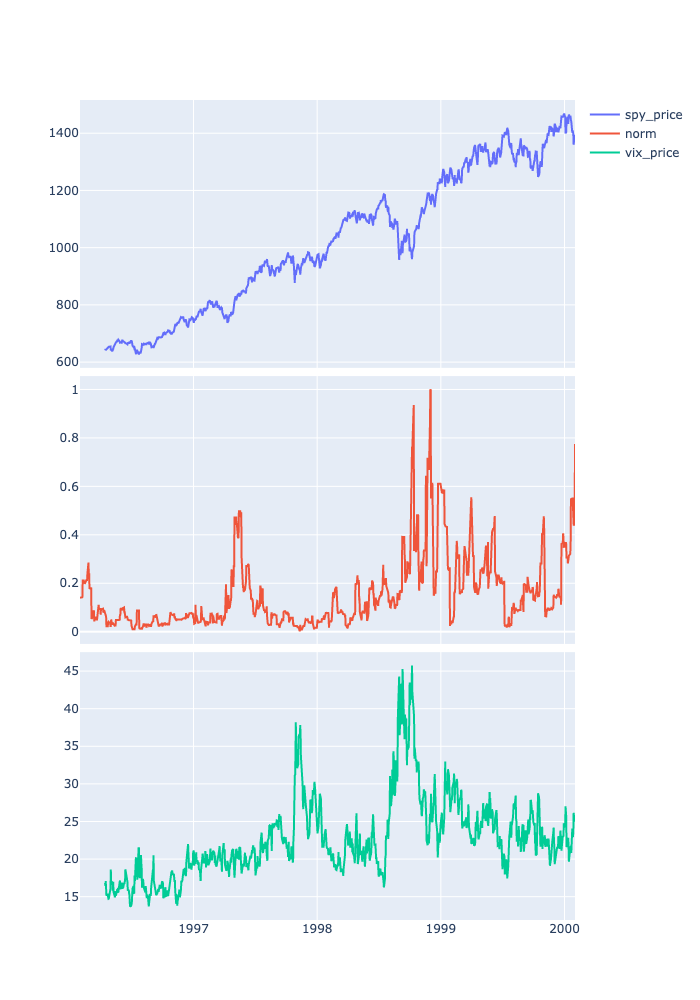

In [11]:
from IPython import display
display.Image("../images/figure10.png")

In [7]:
# Market activity from 2017, stride

dates = ["2017-01-01", "2021-08-21"]
clean_data = yf.download("^GSPC ^VIX", start=dates[0], end=dates[1], interval = "1d", group_by = "ticker").xs("Adj Close", level=1, axis=1)

calced_df = pd.DataFrame(
    {
        # "log_price": log_price[1:],
        "spy_price": clean_data["^GSPC"][50:],
        "norm": norm[:,1][1:],
        "vix_price": clean_data["^VIX"][50:]
        # "log_returns": np.diff(log_price),
    },
    index = y_sw[1:]
)


fig = make_subplots(rows=len(calced_df.keys()), cols=1, shared_xaxes=True, vertical_spacing = 0.01)
fig.update_layout(
    height=1000,
)

# plot all time series in calced_df, if norm, first normalize array then plot
for i, col in enumerate(calced_df.keys(), start=1):
    if col == "norm":
        normed_norm = calced_df[dates[0]:dates[1]][col].values/max(calced_df[dates[0]:dates[1]][col].values)
        fig.add_trace(go.Scatter(x=calced_df[dates[0]:dates[1]][col].index, y=normed_norm, name=col), row=i, col=1)
    else:
        fig.add_trace(go.Scatter(x=calced_df[dates[0]:dates[1]][col].index, y=calced_df[dates[0]:dates[1]][col].values, name=col), row=i, col=1)
    
fig.show()


[*********************100%***********************]  2 of 2 completed


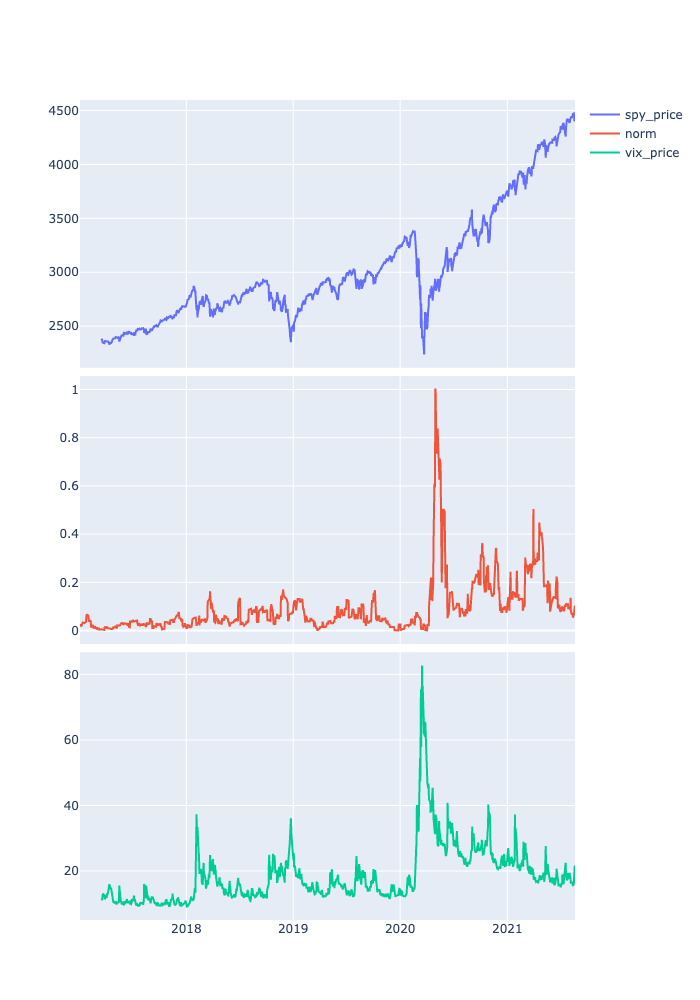

In [13]:
from IPython import display
display.Image("../images/fig10later.png")

## Now, experimenting with using different combination of time series for TDA

Research has discussed correlations between [crude oil](https://www.cmegroup.com/education/files/why-are-equities-moving-in-tandem-with-oil.pdf), [ten year yield](https://www.rba.gov.au/publications/bulletin/2014/sep/pdf/bu-0914-8.pdf), and even [the dollar index](https://www.bis.org/publ/r_qt0008e.pdf) and equities. 

Now we will see if this combination yields signficantly distinct results from the original research paper

In [8]:
# downloading data

# oil, ten year yield, dollar index respectively. downloading earliest data


data = yf.download("CL=F ^TNX DX-Y.NYB, ^GSPC", start="2000-08-23", end="2021-08-20", interval = "1d", group_by = "ticker")
data_df = np.log(data.xs("Adj Close", level=1, axis=1).pct_change()+1)[1:].fillna(-.3)

wins = [50, 100]

[*********************100%***********************]  4 of 4 completed


In [9]:
x, dates = data_df.to_numpy(), data_df.index

SW = SlidingWindow(size=50, stride = 2)
x_sw, y_sw  = SW.fit_transform_resample(x, dates)

VR = VietorisRipsPersistence(homology_dimensions=[0,1], n_jobs=6)
x_vr = VR.fit_transform(X = x_sw)

Ampl = Amplitude(metric="landscape", metric_params={"p":1})
norm = Ampl.fit_transform(X=x_vr)

In [10]:
# constructing plots using new combination of time series

dates = ["2017-01-01", "2021-08-21"]
clean_data = yf.download("^GSPC ^VIX", start=dates[0], end=dates[1], interval = "1d", group_by = "ticker").xs("Adj Close", level=1, axis=1)

calced_df = pd.DataFrame(
    {
        # "log_price": log_price[1:],
        "spy_price": clean_data["^GSPC"][50:],
        "norm": norm[:,1][1:],
        "vix_price": clean_data["^VIX"][50:]
        # "log_returns": np.diff(log_price),
    },
    index = y_sw[1:]
)



fig = make_subplots(rows=len(calced_df.keys()), cols=1, shared_xaxes=True, vertical_spacing = 0.01)
fig.update_layout(
    height=1000,
)

for i, col in enumerate(calced_df.keys(), start=1):
    if col == "norm":
        normed_norm = calced_df[dates[0]:dates[1]][col].values/max(calced_df[dates[0]:dates[1]][col].values)
        fig.add_trace(go.Scatter(x=calced_df[dates[0]:dates[1]][col].index, y=normed_norm, name=col), row=i, col=1)
    else:
        fig.add_trace(go.Scatter(x=calced_df[dates[0]:dates[1]][col].index, y=calced_df[dates[0]:dates[1]][col].values, name=col), row=i, col=1)
    
fig.show()

# to get better or difference results, change which homology is being used for the norm

[*********************100%***********************]  2 of 2 completed


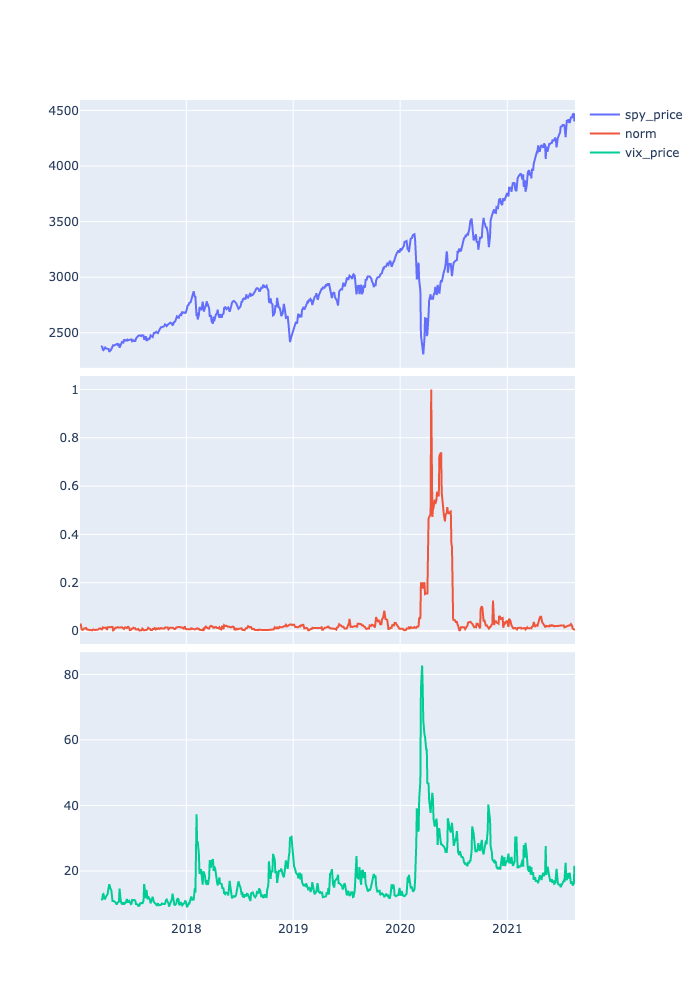

In [14]:
from IPython import display
display.Image("../images/fig10newcombo.png")

We see that the norms still resemble each other, albiet with slight differences. Further experimentation is required to see if any statistical results can be derived